Permalink: https://colab.research.google.com/drive/1_i4gNRllrtMNd91Y_YhqhPx1Yx2iRAef

# Preparation

In [0]:
%matplotlib inline

In [2]:
import tensorflow as tf
tf.__version__

'1.10.1'

In [3]:
import keras
keras.__version__

Using TensorFlow backend.


'2.1.6'

In [0]:
# https://github.com/keras-team/keras/issues/9621#issuecomment-384427194
#!pip install keras==2.1.3 tensorflow-gpu==1.4
#!pip install -U keras tensorflow-gpu

In [5]:
!test -f notMNIST_large.tar.gz || curl -O -# https://commondatastorage.googleapis.com/books1000/notMNIST_large.tar.gz
!test -f notMNIST_small.tar.gz || curl -O -# https://commondatastorage.googleapis.com/books1000/notMNIST_small.tar.gz

!test -d notMNIST_large || tar --checkpoint=10000 -xzf notMNIST_large.tar.gz
!test -d notMNIST_small || tar --checkpoint=1000 -xzf notMNIST_small.tar.gz

######################################################################## 100.0%
######################################################################## 100.0%
tar: Read checkpoint 10000
tar: Read checkpoint 20000
tar: Read checkpoint 30000
tar: Read checkpoint 40000
tar: Read checkpoint 50000
tar: Read checkpoint 60000
tar: Read checkpoint 1000
tar: Read checkpoint 2000


In [6]:
import os
import os.path
import PIL.Image


for d in ["./notMNIST_large", "./notMNIST_small"]:
  for dirpath, dirnames, filenames in os.walk(d):
    print(dirpath)
    for fname in filenames:
      if os.path.splitext(fname)[1] == '.broken':
        continue
      fpath = os.path.join(dirpath, fname)
      try:
        PIL.Image.open(fpath)
      except OSError:
        print('broken: ' + fpath)
        os.rename(fpath, fpath + '.broken')

./notMNIST_large
./notMNIST_large/I
./notMNIST_large/J
./notMNIST_large/C
./notMNIST_large/H
./notMNIST_large/E
./notMNIST_large/F
./notMNIST_large/B
broken: ./notMNIST_large/B/TmlraXNFRi1TZW1pQm9sZEl0YWxpYy5vdGY=.png
./notMNIST_large/G
./notMNIST_large/A
broken: ./notMNIST_large/A/Um9tYW5hIEJvbGQucGZi.png
broken: ./notMNIST_large/A/SG90IE11c3RhcmQgQlROIFBvc3Rlci50dGY=.png
broken: ./notMNIST_large/A/RnJlaWdodERpc3BCb29rSXRhbGljLnR0Zg==.png
./notMNIST_large/D
broken: ./notMNIST_large/D/VHJhbnNpdCBCb2xkLnR0Zg==.png
./notMNIST_small
./notMNIST_small/I
./notMNIST_small/J
./notMNIST_small/C
./notMNIST_small/H
./notMNIST_small/E
./notMNIST_small/F
broken: ./notMNIST_small/F/Q3Jvc3NvdmVyIEJvbGRPYmxpcXVlLnR0Zg==.png
./notMNIST_small/B
./notMNIST_small/G
./notMNIST_small/A
broken: ./notMNIST_small/A/RGVtb2NyYXRpY2FCb2xkT2xkc3R5bGUgQm9sZC50dGY=.png
./notMNIST_small/D


In [0]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Activation, Dropout
from keras.preprocessing.image import ImageDataGenerator
import matplotlib.pyplot as plt

In [8]:
gen = ImageDataGenerator(rescale=1./255, validation_split=0.1)
training = gen.flow_from_directory("./notMNIST_large", target_size=(28,28), color_mode="grayscale", subset="training")
validation = gen.flow_from_directory("./notMNIST_large", target_size=(28,28), color_mode="grayscale", subset="validation")
test = ImageDataGenerator(rescale=1./255).flow_from_directory("./notMNIST_small", target_size=(28,28), color_mode="grayscale")

Found 476205 images belonging to 10 classes.
Found 52909 images belonging to 10 classes.
Found 18724 images belonging to 10 classes.


J


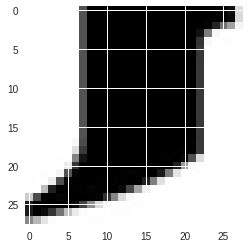

D


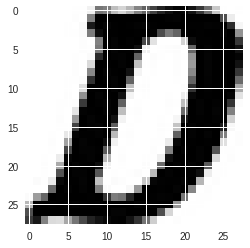

C


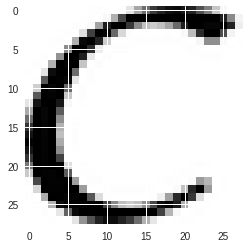

A


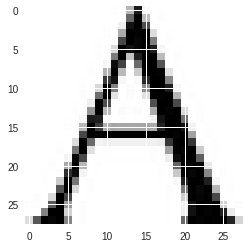

G


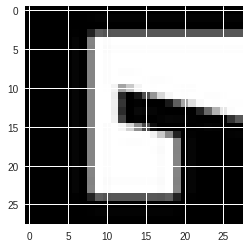

H


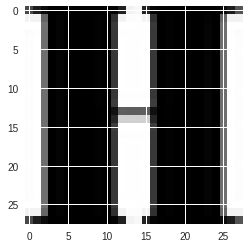

I


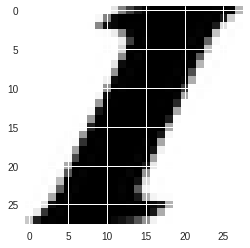

G


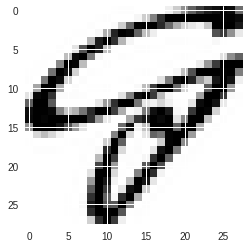

H


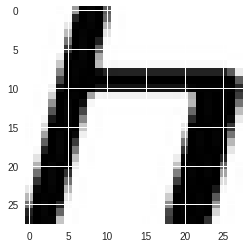

H


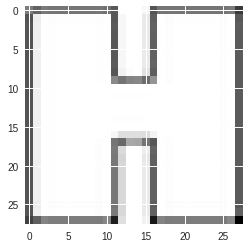

C


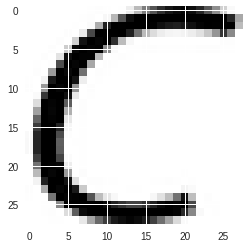

A


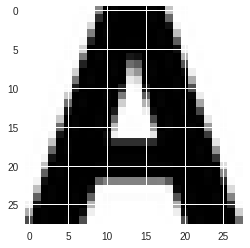

H


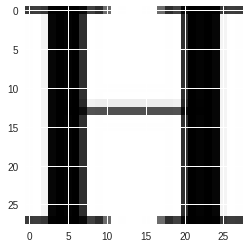

G


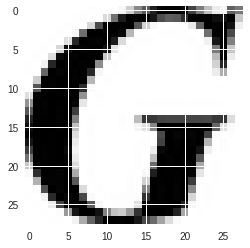

B


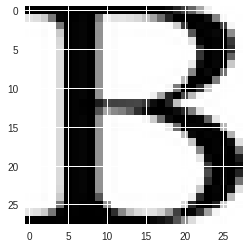

A


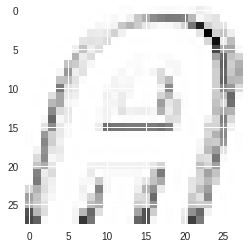

H


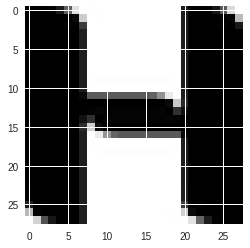

I


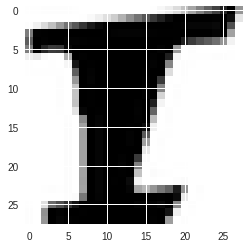

B


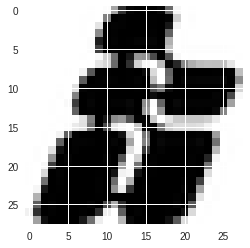

J


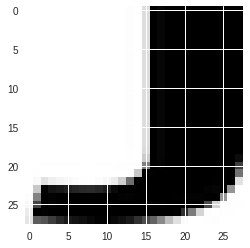

G


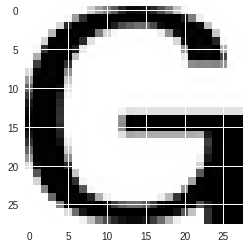

I


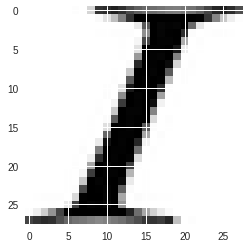

J


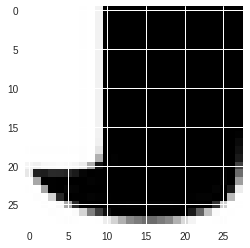

H


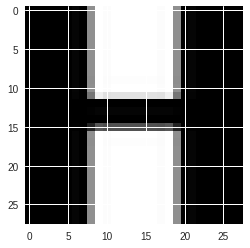

D


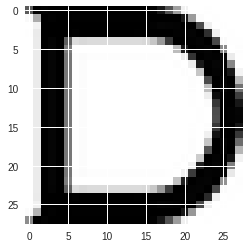

H


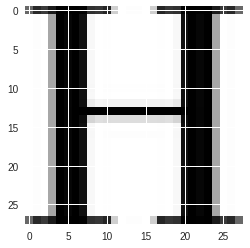

B


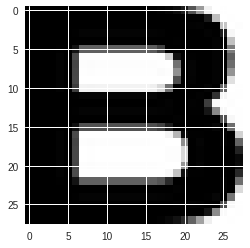

I


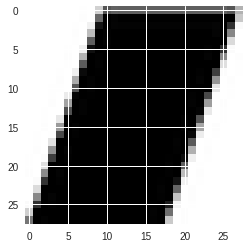

B


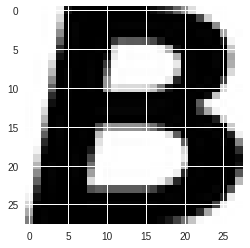

B


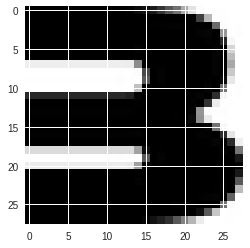

E


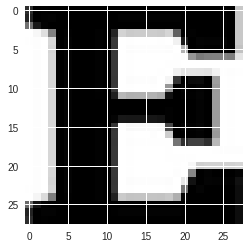

A


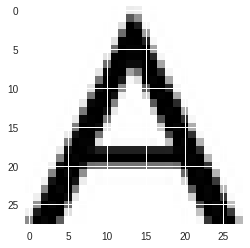

In [23]:
import numpy as np

labels = "ABCDEFGHIJ"

xs, ys = training.next()
for i, x in enumerate(xs):
  print(labels[np.argmax(ys[i])])
  plt.imshow(x[:,:,0])
  plt.show()
training.reset()

# Training

In [0]:
model = Sequential()
model.add(Conv2D(32, kernel_size=(7,7), input_shape=(28,28,1), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(64, kernel_size=(7,7), padding='same'))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dense(512))
model.add(Activation('relu'))
model.add(Dense(64))
model.add(Activation('relu'))
model.add(Dense(10))
model.add(Activation('softmax'))

In [11]:
model.summary()
model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.05),
              metrics=['accuracy'])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 28, 28, 32)        1600      
_________________________________________________________________
activation_1 (Activation)    (None, 28, 28, 32)        0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 14, 14, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 14, 14, 64)        100416    
_________________________________________________________________
activation_2 (Activation)    (None, 14, 14, 64)        0         
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 7, 7, 64)          0         
_________________________________________________________________
flatten_1 (Flatten)          (None, 3136)              0         
__________

In [12]:
training.reset()
hist = model.fit_generator(training, epochs=10, steps_per_epoch=5000, validation_data=validation)
dict(zip(model.metrics_names, model.evaluate_generator(test)))

Epoch 1/10
5000/5000 [==============================] - 108s 22ms/step - loss: 0.4212 - acc: 0.8734 - val_loss: 0.2770 - val_acc: 0.9187
Epoch 2/10
5000/5000 [==============================] - 105s 21ms/step - loss: 0.2966 - acc: 0.9088 - val_loss: 0.2430 - val_acc: 0.9277
Epoch 3/10
5000/5000 [==============================] - 104s 21ms/step - loss: 0.2715 - acc: 0.9156 - val_loss: 0.2209 - val_acc: 0.9321
Epoch 4/10
5000/5000 [==============================] - 103s 21ms/step - loss: 0.2440 - acc: 0.9232 - val_loss: 0.2156 - val_acc: 0.9342
Epoch 5/10
5000/5000 [==============================] - 103s 21ms/step - loss: 0.2356 - acc: 0.9262 - val_loss: 0.2089 - val_acc: 0.9364
Epoch 6/10
5000/5000 [==============================] - 103s 21ms/step - loss: 0.2280 - acc: 0.9279 - val_loss: 0.2043 - val_acc: 0.9373
Epoch 7/10
5000/5000 [==============================] - 103s 21ms/step - loss: 0.2037 - acc: 0.9351 - val_loss: 0.2037 - val_acc: 0.9387
Epoch 8/10
5000/5000 [===================

{'acc': 0.9762871181371502, 'loss': 0.08168154170060922}

label:    F
predict:  F


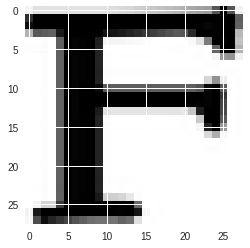

label:    J
predict:  J


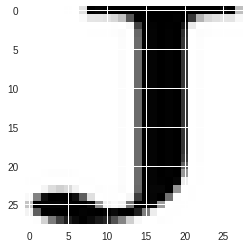

label:    G
predict:  G


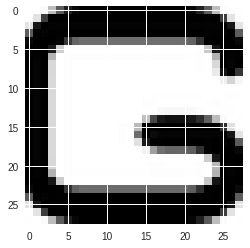

label:    D
predict:  D


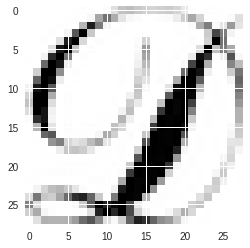

label:    D
predict:  D


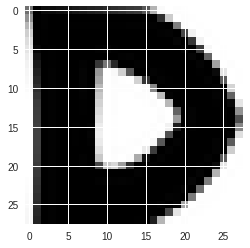

label:    A
predict:  A


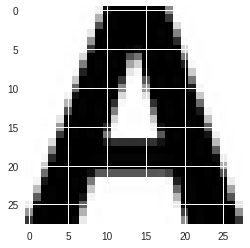

label:    A
predict:  A


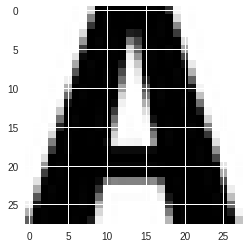

label:    J
predict:  J


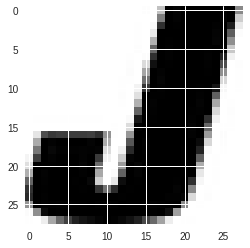

label:    J
predict:  J


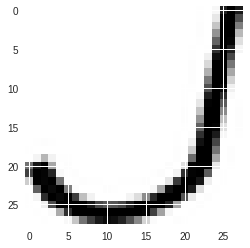

label:    B
predict:  B


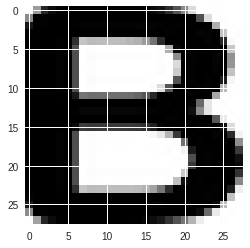

label:    D
predict:  D


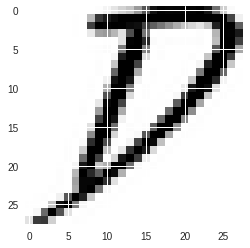

label:    G
predict:  G


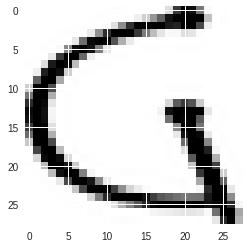

label:    A
predict:  A


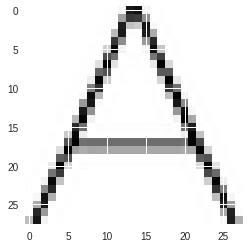

label:    E
predict:  E


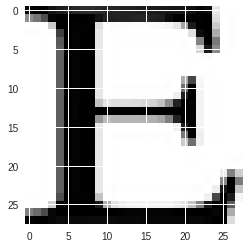

label:    I
predict:  I


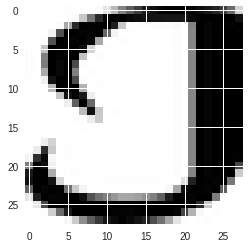

label:    E
predict:  E


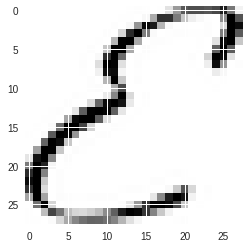

label:    F
predict:  F


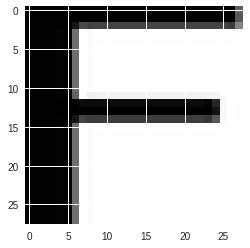

label:    F
predict:  F


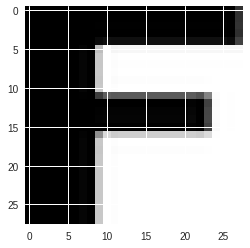

label:    G
predict:  G


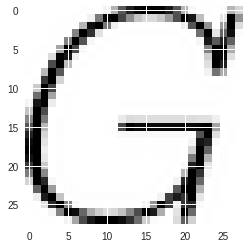

label:    F
predict:  F


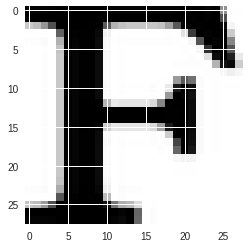

label:    C
predict:  C


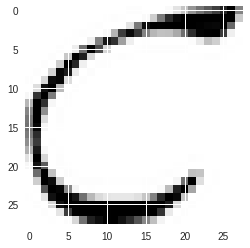

label:    H
predict:  H


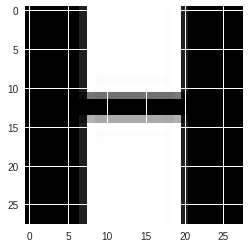

label:    A
predict:  A


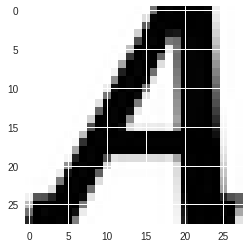

label:    G
predict:  G


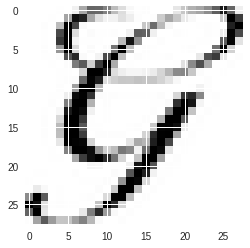

label:    E
predict:  E


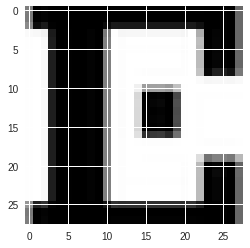

label:    D
predict:  D


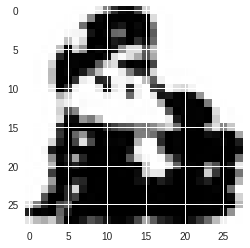

label:    G
predict:  G


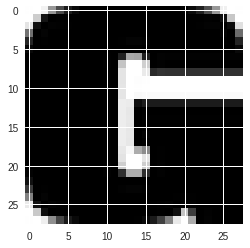

label:    C
predict:  C


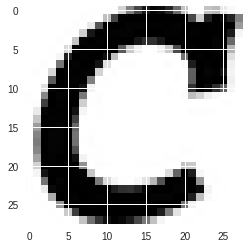

label:    H
predict:  H


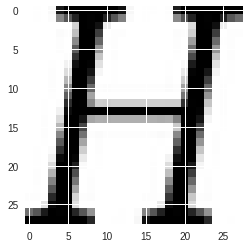

label:    G
predict:  G


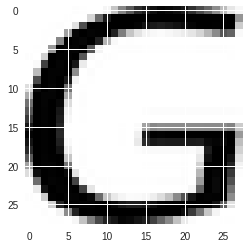

label:    E
predict:  E


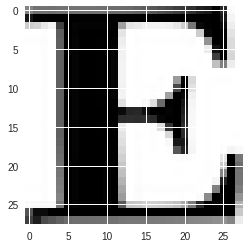

label:    D
predict:  D


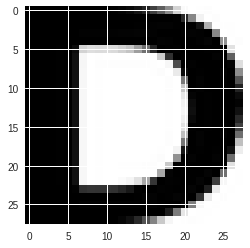

In [22]:
import numpy as np

labels = "ABCDEFGHIJ"

test.reset()
xs, ys = test.next()
for i, x in enumerate(xs):
  print("label:   ", labels[np.argmax(ys[i])])
  print("predict: ", labels[np.argmax(model.predict(x[None, ...]))])
  plt.imshow(x[:,:,0])
  plt.show()

# Download the model in Tensorflow.js format

In [0]:
model.save('model.h5')

In [14]:
!pip3 install tensorflowjs

    100% |████████████████████████████████| 12.2MB 3.0MB/s 
    100% |████████████████████████████████| 61kB 18.8MB/s 
    100% |████████████████████████████████| 51.1MB 609kB/s 
    100% |████████████████████████████████| 3.3MB 6.7MB/s 
  Found existing installation: numpy 1.14.5
    Uninstalling numpy-1.14.5:
      Successfully uninstalled numpy-1.14.5
  Found existing installation: tensorflow-hub 0.1.1
    Uninstalling tensorflow-hub-0.1.1:
      Successfully uninstalled tensorflow-hub-0.1.1
  Found existing installation: tensorboard 1.10.0
    Uninstalling tensorboard-1.10.0:
      Successfully uninstalled tensorboard-1.10.0
  Found existing installation: tensorflow 1.10.1
    Uninstalling tensorflow-1.10.1:
      Successfully uninstalled tensorflow-1.10.1


In [15]:
!tensorflowjs_converter --input_format keras model.h5 model

Using TensorFlow backend.


In [16]:
!tar cvzf model.tar.gz model

model/
model/model.json
model/group1-shard2of2
model/group1-shard1of2


In [0]:
from google.colab import files

files.download('model.tar.gz')